<a href="https://colab.research.google.com/github/ean0418/ean0418/blob/main/Aug13_1_tf_bmi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
# BMI 계산 후 레이블 리턴하는 함수
# bmi = kg / m * m
#     18.5 미만 : thin
#     25 미만 : normal
#     25 이상 : fat
import random

def bimando(height, weight):
    bmi = weight / (height / 100) ** 2
    if bmi < 18.5: return "thin"
    elif bmi < 25: return "normal"
    return "fat"
f = open("bmi.csv", "w", encoding="utf-8")
f.write("height,weight,label\n")

s = {'thin' : 0, 'normal' : 0, 'fat' : 0}

for i in range(20000):
  height = random.randint(120, 200)
  weight = random.randint(30, 90)
  label = bimando(height, weight)
  s[label] += 1
  f.write("{0},{1},{2}\n".format(height, weight, label))
f.close()
print(s)

# 키 : cm (120~200 사이의 정수)
# 몸무게 : kg(30~90 사이의 정수)

# 데이터 무작위로 20000개 생성
# {'thin' : 0, 'normal' : 0, 'fat' : 0}


# csv 파일 생성
#   키, 몸무게, label 의 형태로



{'thin': 6220, 'normal': 5323, 'fat': 8457}


In [39]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf

tf.compat.v1.disable_eager_execution()

In [40]:
# csv 파일 읽어오기
csv = pd.read_csv('bmi.csv')
print(csv.shape)
csv.head()

(20000, 3)


,height,weight,label
0,129,78,fat
1,149,54,normal
2,189,54,thin
3,137,43,normal
4,188,65,thin


In [41]:
# 키와 몸무게 기초 통계량 확인
csv.describe()

,height,weight
count,20000.000000,20000.000000
mean,160.026700,59.967150
std,23.347258,17.610993
min,120.000000,30.000000
25%,140.000000,45.000000
50%,160.000000,60.000000
75%,180.000000,75.000000
max,200.000000,90.000000


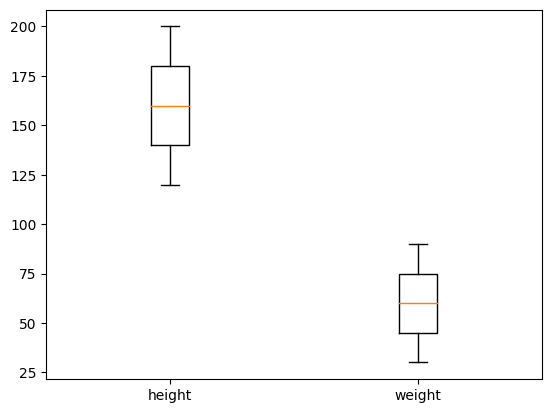

In [42]:
# boxplot으로 h, w 분포 확인
import matplotlib.pyplot as plt

plt.boxplot([csv['height'],csv['weight']], labels=['height','weight'])
plt.show()

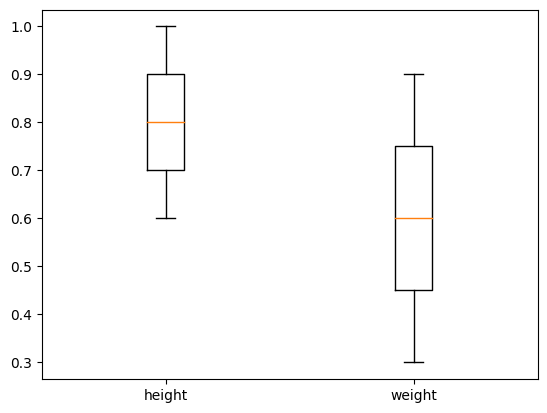

In [43]:
# 복제본
csv1 = csv.copy()

# 키가 2미터를 넘지 않고, 뭄무게는 100키로가 넘지 않는다는 가정하에...
# 정규화
csv1['height'] = csv1['height'] / 200
csv1['weight'] = csv1['weight'] / 100

plt.boxplot([csv1['height'], csv1['weight']], labels=['height', 'weight'])
plt.show()

In [44]:
# 레이블을 배열로 변환
# str => One-Hot Encoding으로 converting
# thin : [1,0,0], notmal : [0,1,0], fat : [0,0,1]
ohe = {'thin':[1,0,0], 'normal':[0,1,0], 'fat':[0,0,1]}
# One-Hot Encoding으로 바꾼 내용의 컬럼을 하나 더 생성
csv1['label_ohe'] = csv1['label'].apply(lambda x : np.array(ohe[x]))

csv1

,height,weight,label,label_ohe
0,0.645,0.78,fat,"[0, 0, 1]"
1,0.745,0.54,normal,"[0, 1, 0]"
2,0.945,0.54,thin,"[1, 0, 0]"
3,0.685,0.43,normal,"[0, 1, 0]"
4,0.940,0.65,thin,"[1, 0, 0]"
...,...,...,...,...
19995,0.645,0.50,fat,"[0, 0, 1]"
19996,0.680,0.38,normal,"[0, 1, 0]"
19997,0.920,0.90,fat,"[0, 0, 1]"
19998,0.940,0.65,thin,"[1, 0, 0]"


In [45]:
# 테스트를 위한 데이터 분리 (테스트용 데이터)

# 뒤쪽의 5000개를 테스트데이터로 분리
test_csv = csv1[15000:]
test_pat = test_csv[['height', 'weight']]
test_ans = list(test_csv['label_ohe'])

print(test_pat.head())
print(test_ans[:5])

       height  weight
15000   0.685    0.88
15001   0.970    0.63
15002   0.735    0.37
15003   0.710    0.87
15004   0.685    0.38
[array([0, 0, 1]), array([1, 0, 0]), array([1, 0, 0]), array([0, 0, 1]), array([0, 1, 0])]


In [46]:
# tensorflow의 학습 모델 구성

tf.reset_default_graph()
# 기존에 생성된 데이터 플로우 그래프를 모두 삭제하고 reset시켜서 중복 방지
# 데이터 플로우 그래프 : 계산이나 데이터의 흐름을 표현하기 위한 그래프


In [48]:
# 신경망 구성

# 데이터 플로우 그래프 구축하기
# placeholder 생성

# 키와 몸무게 데이터 넣기
x = tf.placeholder(tf.float32, [None, 2])
# 레이블 넣기
y_ = tf.placeholder(tf.float32, [None, 3])

# 변수 선언
W = tf.Variable(tf.zeros([2,3]))
# 가중치 행령 W를 0으로 초기화된 2행 3열의 행렬
#   입력 차원 : 2 (키와 몸무게)
#   출력 차원 : 3 ('thin','normal','fat' 의 3가지 클래스)

b = tf.Variable(tf.zeros([3]))
# 바이어스(bias) : 뉴런의 활성화를 조절
# 바이어스를 0으로 초기화된 3개의 요소를 가진 벡터로 정의
# 각 출력 노드(thin, normal, fat)에 대해 하나씩의 바이어스 값을 가짐

# 소프트맥스 회귀 : one-hot encoding과 연결하기 위해서 0~1 사이의 숫자로 바꾸는 역할
#                   여러개의 클래스(결과)를 분류하기 위한 방법
y = tf.nn.softmax(tf.matmul(x,W) + b)

# 손실함수의 cross entropy :
# cross entropy : 모델에서 예측한 값과 실제 정답이 틀릴 수 있다 라는 정보량
# 분류 모델이 얼마나 잘 수행되는지 측정하기 위해서 사용하는 지표
#   y_ * tf.log(y) 에는 크로스 엔트로피들의 2차원 텐서가 들어있음
#   reduce_sum() 함수는 지정된 차원에 따라서 평균을 내는 함수
# 크로스 엔트로피(데이터의 불확실성)에서는 실제값과 예측값이 맞는 경우 0으로 수렴하고,
# 값이 틀릴 경우에는 값이 커지기 때문에...=> 실제값과 예측값의 차이를 줄이기 위한...
ce = -tf.reduce_sum(y_ * tf.log(y))

# 최적화 : 경사하강법(함수의 기울기(경사)를 구하고, 경사의 절대값이 낮은쪽으로 이동시켜서
#                        극값에 이를때까지 반복하는 것 )
#                  => 예측 결과와 실제 결과 간의 오류를 최소화하여 모델 학습을 진행
optimizer = tf.train.GradientDescentOptimizer(0.01) # 학습 계수(하강 간격) : 0.01

# gradient : 경사 / descent : 내려감 >> 경사를 따라 내려가는 알고리즘
# optimizer : 각각의 변수에 기대되는 값과 손실의 도함수의 정도에 따라서 변수의 값을 변경해줌
#   도함수 : 원래 함수를 미분해서 얻어낸 함수 >> 어떤 점에서의 기울기
# 텐서플로우 : 도함수를 자동으로 만들어줌!

# 가중치, 편차를 보정
optimizer1 = optimizer.minimize(ce)

# 정답률 구하기
# 첫번째 파라미터 : 모델이 생각할 때 가장 적합하다고 판단한 레이블
# 두번쨰 파라미터 : 실제 레이블
# tf.equal()를 이용해서 예측이 맞았는지 확인
predict = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

# 평균 구하기
score = tf.reduce_mean(tf.cast(predict, tf.float32))




In [53]:
# 실세 실행이 이루어지는 Session

with tf.Session() as sess:
  f_bmi = tf.summary.FileWriter('into_bmi', graph=sess.graph) # 그래프를 저장할 파일을 지정
  sess.run(tf.global_variables_initializer()) # 변수 초기화

  # 학습시키기 - 3500번
  for step in range(3500):

    # 0 ~ 14999까지를 100개씩 학습
    i = (step * 100) % 14000

    # 학습이 되는 행을 추출
    rows = csv1[1+i : 1+i+100]

    # feature_data, label_data를 분리
    xf = rows[['height', 'weight']]
    yl = list(rows['label_ohe'])

    feed_dict = {x : xf, y_ : yl}

    # 학습
    sess.run(optimizer1, feed_dict=feed_dict)

    # 학습된 모델을 가지고 test를 진행할 때 중간중간 콘솔에서 확인할 수 있도록
    if step % 500 == 0: # 500번 마다(반복횟수)
      ce1 = sess.run(ce, feed_dict={x : test_pat, y_ : test_ans})
      ac = sess.run(score, feed_dict={x : test_pat, y_ : test_ans})
      print('단계=', step, '크로스엔트로피=',ce1,'정확도=', ac)

    # 최종 정답률(정확도)
  ac = sess.run(score, feed_dict={x : test_pat, y_ : test_ans})
  print('정확도=', ac)

단계= 0 크로스엔트로피= 5539.048 정확도= 0.3078
단계= 500 크로스엔트로피= 2554.3687 정확도= 0.8148
단계= 1000 크로스엔트로피= 2082.9417 정확도= 0.916
단계= 1500 크로스엔트로피= 1820.2557 정확도= 0.9316
단계= 2000 크로스엔트로피= 1662.4285 정확도= 0.9254
단계= 2500 크로스엔트로피= 1542.5626 정확도= 0.94
단계= 3000 크로스엔트로피= 1462.2263 정확도= 0.9324
정확도= 0.9588
